## Problem Definition
In this notebook, we will create time serie driven forecasting engine based on 2 time series models. The dataset we are using is the 'VIETNAM macroeconomics data'. It is a quarterly dataset starting from 2015 and goes on till April 2024. The target variable is 'Tổng sản phẩm trong nước theo giá so sánh' and there 18 features which can help us forecast HK flat price. The dataset can be found https://vbma.org.vn/vi/market-data/gdp-industry-group


We will first do exploratory data analysis on the data, we do the following:

1. Load data from CSV
2. Tranform 'quarter' attribute to 'date'
3. Check if any data are missing
4. Create a correlation heatmap
5. Create the time series subplots 

Once the data has been cleaned up, we do:

1. Augmented Dickey-Fuller (ADF) test
2. Differencing to achieve stationarity
3. Exploratory Data Analysis by Autocorrelation Analysis
4. Split dataset to forecast

Finally, we train 2 models:

1. ARIMA (Univariate Time Series)
2. SARIMA (Univariate Time Series)

We make predictions for the 7 quarterly using all the models.

## Data Collection

In [258]:
# Import Necessary Libraries

#!pip install pyod

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectFromModel

import statsmodels.api as sm
from scipy.stats.mstats import zscore

import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas import Series
from matplotlib import pyplot

import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from  statsmodels.tsa.vector_ar.vecm import *


import itertools
import math
import random
import tensorflow
import keras
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
# Suppress warnings
warnings.filterwarnings("ignore")

### Load data from CSV

In [259]:
# Load the CSV file into a DataFramed
df = pd.read_csv("data/vietnam_macro_economic_detail.csv")
# Display the first few rows of the DataFrame to understand its structure
print(df.head())

      date Tổng sản phẩm trong nước theo giá so sánh  \
0  Q1 2015                                   535,045   
1  Q2 2015                                   690,267   
2  Q3 2015                                   729,639   
3  Q4 2015                                   920,906   
4  Q1 2016                                   564,371   

  Nông nghiệp, lâm nghiệp và thủy sản  Nông nghiệp Lâm nghiệp Thủy sản  \
0                               67,012      49,790      3,617   13,604   
1                              142,640     114,829      4,163   23,648   
2                              112,372      80,688      5,521   26,163   
3                              140,513     106,617      6,217   27,679   
4                               66,131      48,451      3,818   13,863   

  Công nghiệp Công nghiệp chế biến, chế tạo  \
0     159,521                        91,090   
1     192,341                       108,683   
2     198,579                       114,449   
3     259,997                 

In [260]:
#Check number of rows and columns, type of each columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 20 columns):
 #   Column                                                                           Non-Null Count  Dtype 
---  ------                                                                           --------------  ----- 
 0   date                                                                             37 non-null     object
 1   Tổng sản phẩm trong nước theo giá so sánh                                        37 non-null     object
 2   Nông nghiệp, lâm nghiệp và thủy sản                                              37 non-null     object
 3   Nông nghiệp                                                                      37 non-null     object
 4   Lâm nghiệp                                                                       37 non-null     object
 5   Thủy sản                                                                         37 non-null     object
 6   Công nghiệp         

In [261]:
# Understanding the numeric fields
df.describe()

,date,Tổng sản phẩm trong nước theo giá so sánh,"Nông nghiệp, lâm nghiệp và thủy sản",Nông nghiệp,Lâm nghiệp,Thủy sản,Công nghiệp,"Công nghiệp chế biến, chế tạo","Sản xuất và phân phối điện, khí đốt, nước nóng, hơi nước và điều hòa không khí",Ngành công nghiệp khác,Xây dựng,Dịch vụ,"Bán buôn bán lẻ, sửa chữa ô tô, mô tô, xe máy và xe có động cơ khác",Vận tải kho bãi,Dịch vụ lưu trú và ăn uống,"Hoạt động tài chính, ngân hàng và bảo hiểm",Hoạt động kinh doanh bất động sản,Y tế và hoạt động cứu trợ xã hội,Dịch vụ khác,Khác
count,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37
unique,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37
top,Q1 2015,"535,045","67,012","49,790","3,617","13,604","159,521","91,090","22,078","46,353","25,791","216,309","54,948","16,598","22,767","20,935","33,735","6,823","60,504","66,412"
freq,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


=> Không có dữ liệu rỗng

## Data Preprocessing

### Custom data

In [262]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to convert the custom date format
def convert_quarter(date_str):
    # Map quarters to start month
    quarter_map = {
        'Q1': '01', 'Q2': '04', 'Q3': '07', 'Q4': '10'
    }
    quarter, year = date_str.split()
    month = quarter_map[quarter]
    return pd.to_datetime(f'{year}-{month}-01')


# Convert the time column using the custom function
time_column = 'date'  # Update this to the actual column name
df[time_column] = df[time_column].apply(convert_quarter)

# Remove commas and convert all columns to float
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].str.replace(',', '').astype(float)
        


# Check the first few rows of the dataframe
print(df.head())

        date  Tổng sản phẩm trong nước theo giá so sánh  \
0 2015-01-01                                   535045.0   
1 2015-04-01                                   690267.0   
2 2015-07-01                                   729639.0   
3 2015-10-01                                   920906.0   
4 2016-01-01                                   564371.0   

   Nông nghiệp, lâm nghiệp và thủy sản   Nông nghiệp  Lâm nghiệp  Thủy sản  \
0                               67012.0      49790.0      3617.0   13604.0   
1                              142640.0     114829.0      4163.0   23648.0   
2                              112372.0      80688.0      5521.0   26163.0   
3                              140513.0     106617.0      6217.0   27679.0   
4                               66131.0      48451.0      3818.0   13863.0   

   Công nghiệp  Công nghiệp chế biến, chế tạo  \
0     159521.0                        91090.0   
1     192341.0                       108683.0   
2     198579.0               

### Create a correlation heatmap

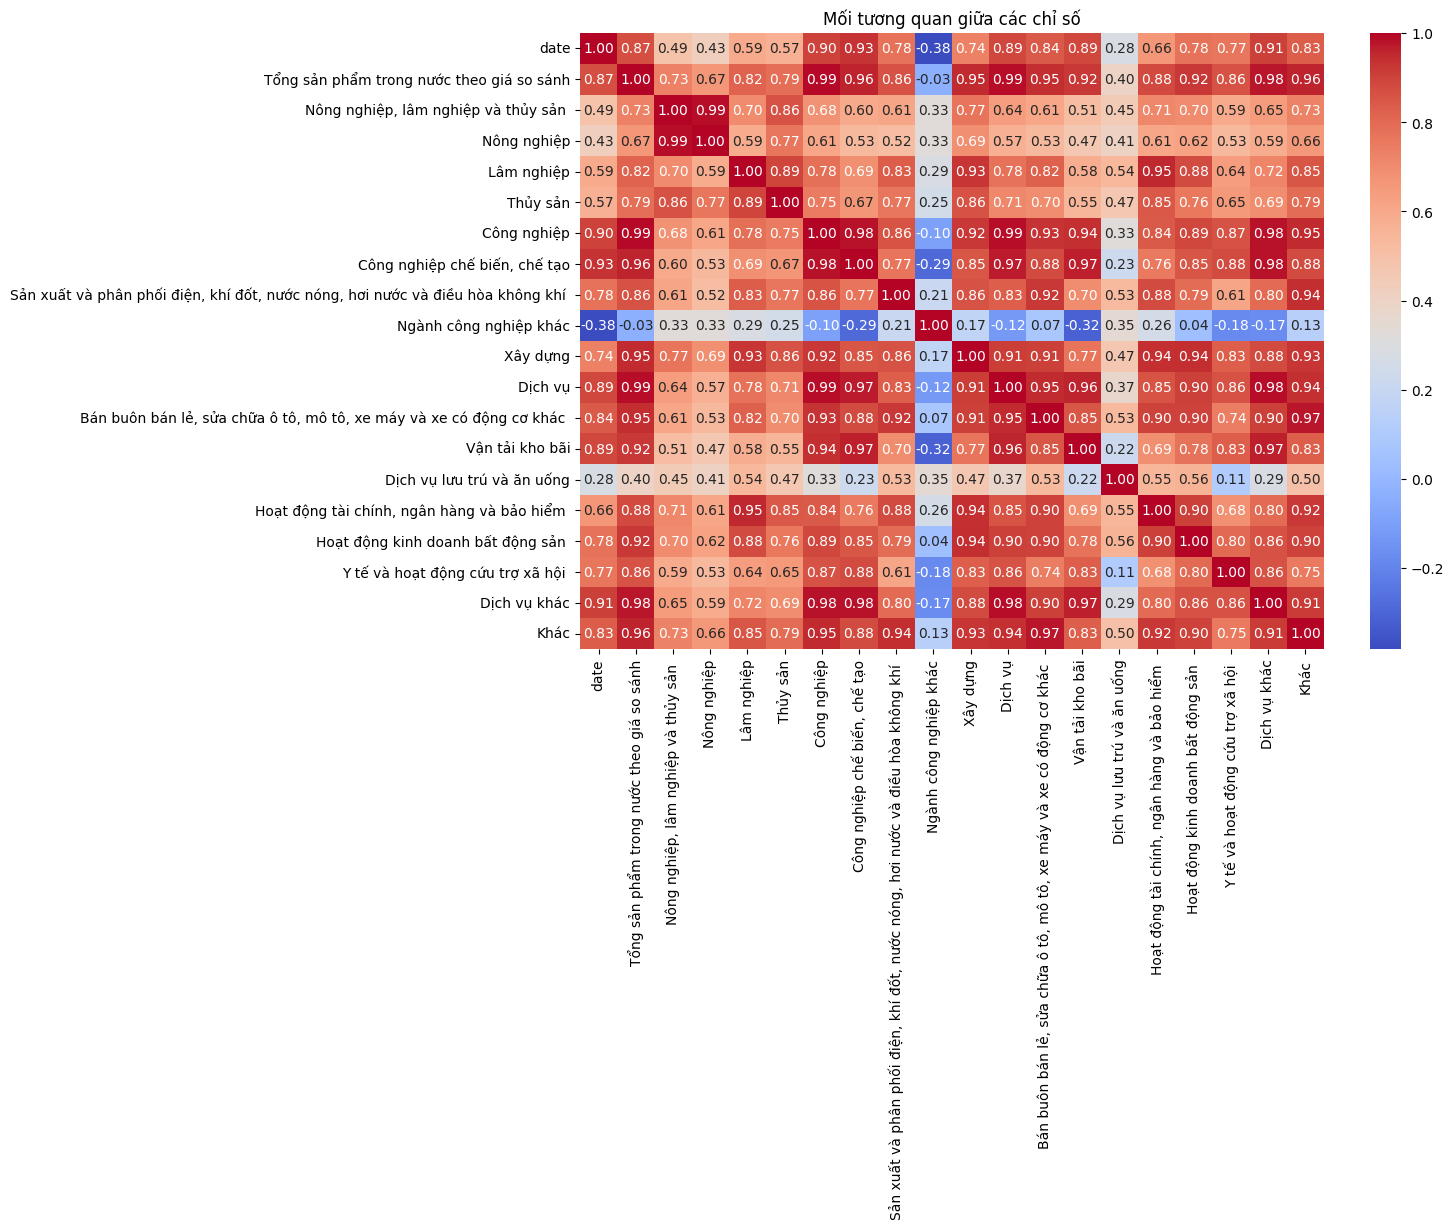

In [263]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Mối tương quan giữa các chỉ số')
plt.show()

Ta thấy, giá trị 'Tổng sản phẩm trong nước theo giá so sánh' tương quan cao so với 'Công nghiệp', 'Dịch vụ', 'Công nghiệp chế biến, chế tạo'. Chứng tỏ:
1.  Các ngành công nghiệp, dịch vụ, và công nghiệp chế biến, chế tạo có thể đóng góp phần lớn vào GDP. Điều này có thể phản ánh một nền kinh tế mà các ngành công nghiệp và dịch vụ là động lực chính.
2.  Những biến động trong các ngành này (tăng trưởng hoặc suy giảm) sẽ có tác động đáng kể lên GDP tổng thể.

### Create the time series subplots 

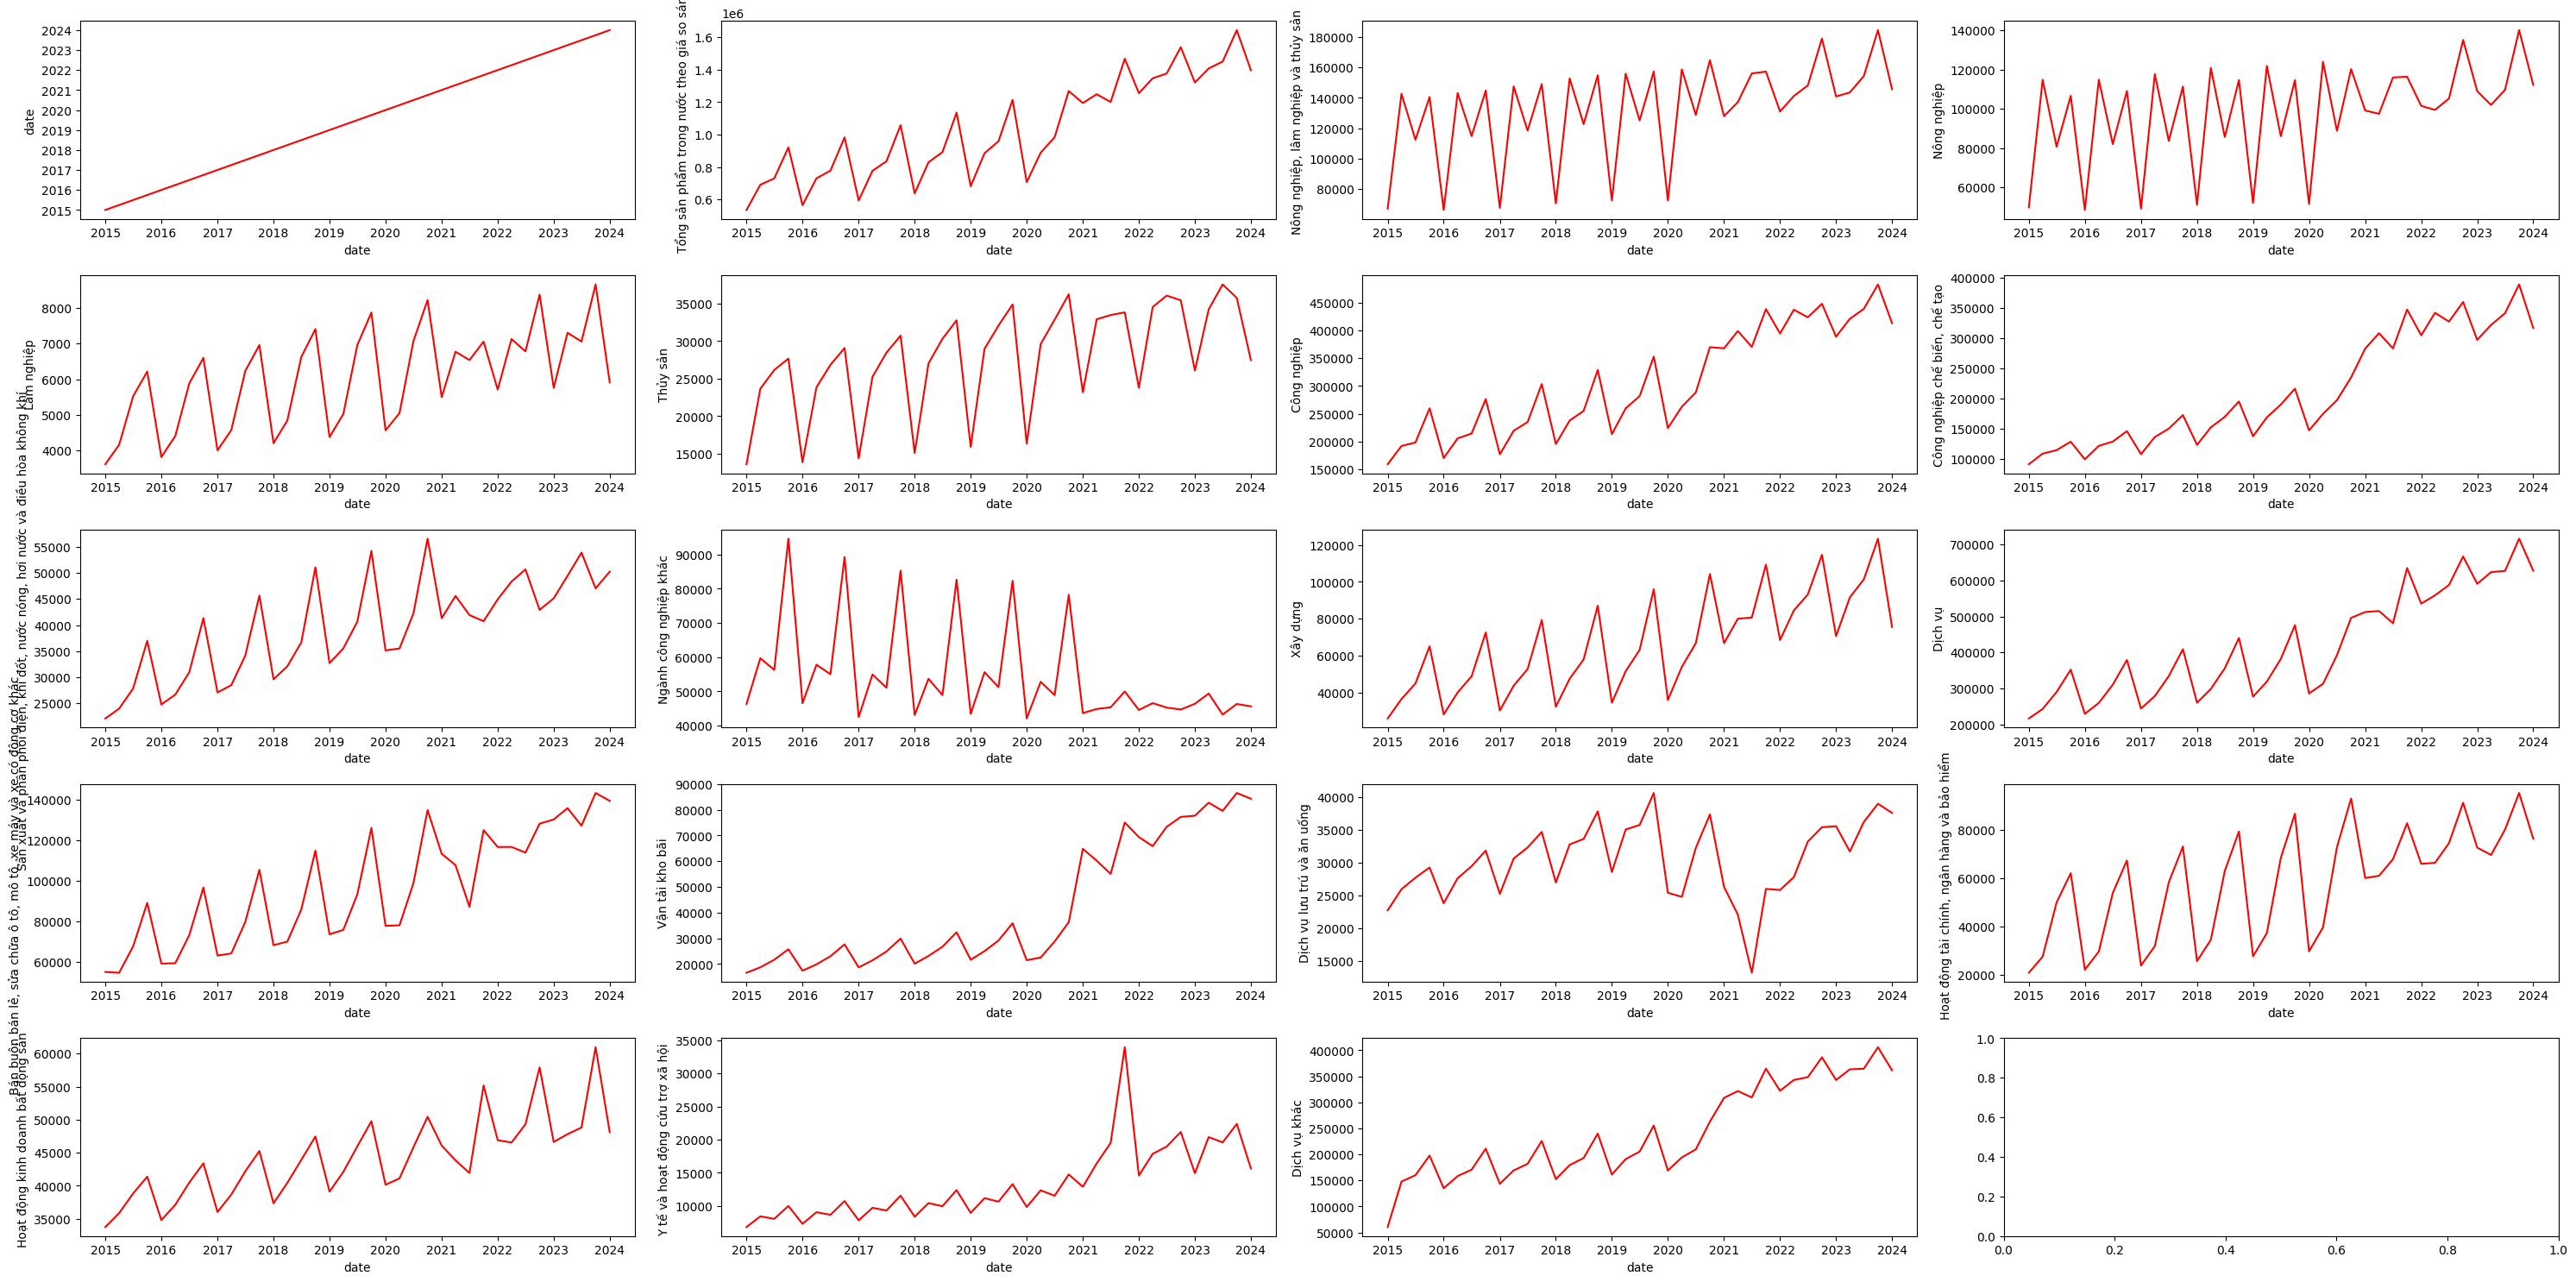

In [264]:
fig,ax =  plt.subplots( 5, 4, 
                       figsize = ( 30, 15))
l = df.columns
k = 0
while (k<len(l)-1):
    for i in range(5):
        for j in range(4):
            if (i!=4 or j!=3):
                sns.lineplot( x = "date", y = l[k],  
                             color = 'r', data = df,  
                             ax = ax[i][j])
                k += 1
fig.tight_layout(pad = 1.2) 

Giá trị quan trọng là 'Tổng sản phẩm trong nước theo giá so sánh':
- Tổng sản phẩm trong nước (GDP) theo giá so sánh có xu hướng tăng lên trong khoảng thời gian từ năm 2015 đến năm 2024. Mặc dù có sự biến động và dao động theo mùa, xu hướng chung là tăng.
- Biểu đồ cho thấy có sự dao động đều đặn theo mùa. Có những khoảng thời gian mà GDP tăng mạnh và sau đó giảm nhẹ rồi lại tăng tiếp. Điều này cho thấy có những yếu tố mùa vụ hoặc chu kỳ ảnh hưởng đến GDP.
- Từ năm 2015 đến khoảng năm 2019, GDP tăng trưởng một cách khá ổn định với mỗi năm đều có sự gia tăng rõ rệt.
- Sau năm 2020, có sự biến động mạnh hơn trong GDP. Biểu đồ cho thấy có sự giảm đáng kể vào năm 2020, có thể liên quan đến các yếu tố kinh tế lớn như đại dịch COVID-19, và sau đó là sự phục hồi mạnh mẽ vào các năm tiếp theo.

### Augmented Dickey-Fuller (ADF) test

- Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).

- Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).

If the null hypothesis can be rejected, we can conclude that the time series is stationary.

There are two ways to rejects the null hypothesis:

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

**p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

**p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.

**ADF statistic > critical value**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

**ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

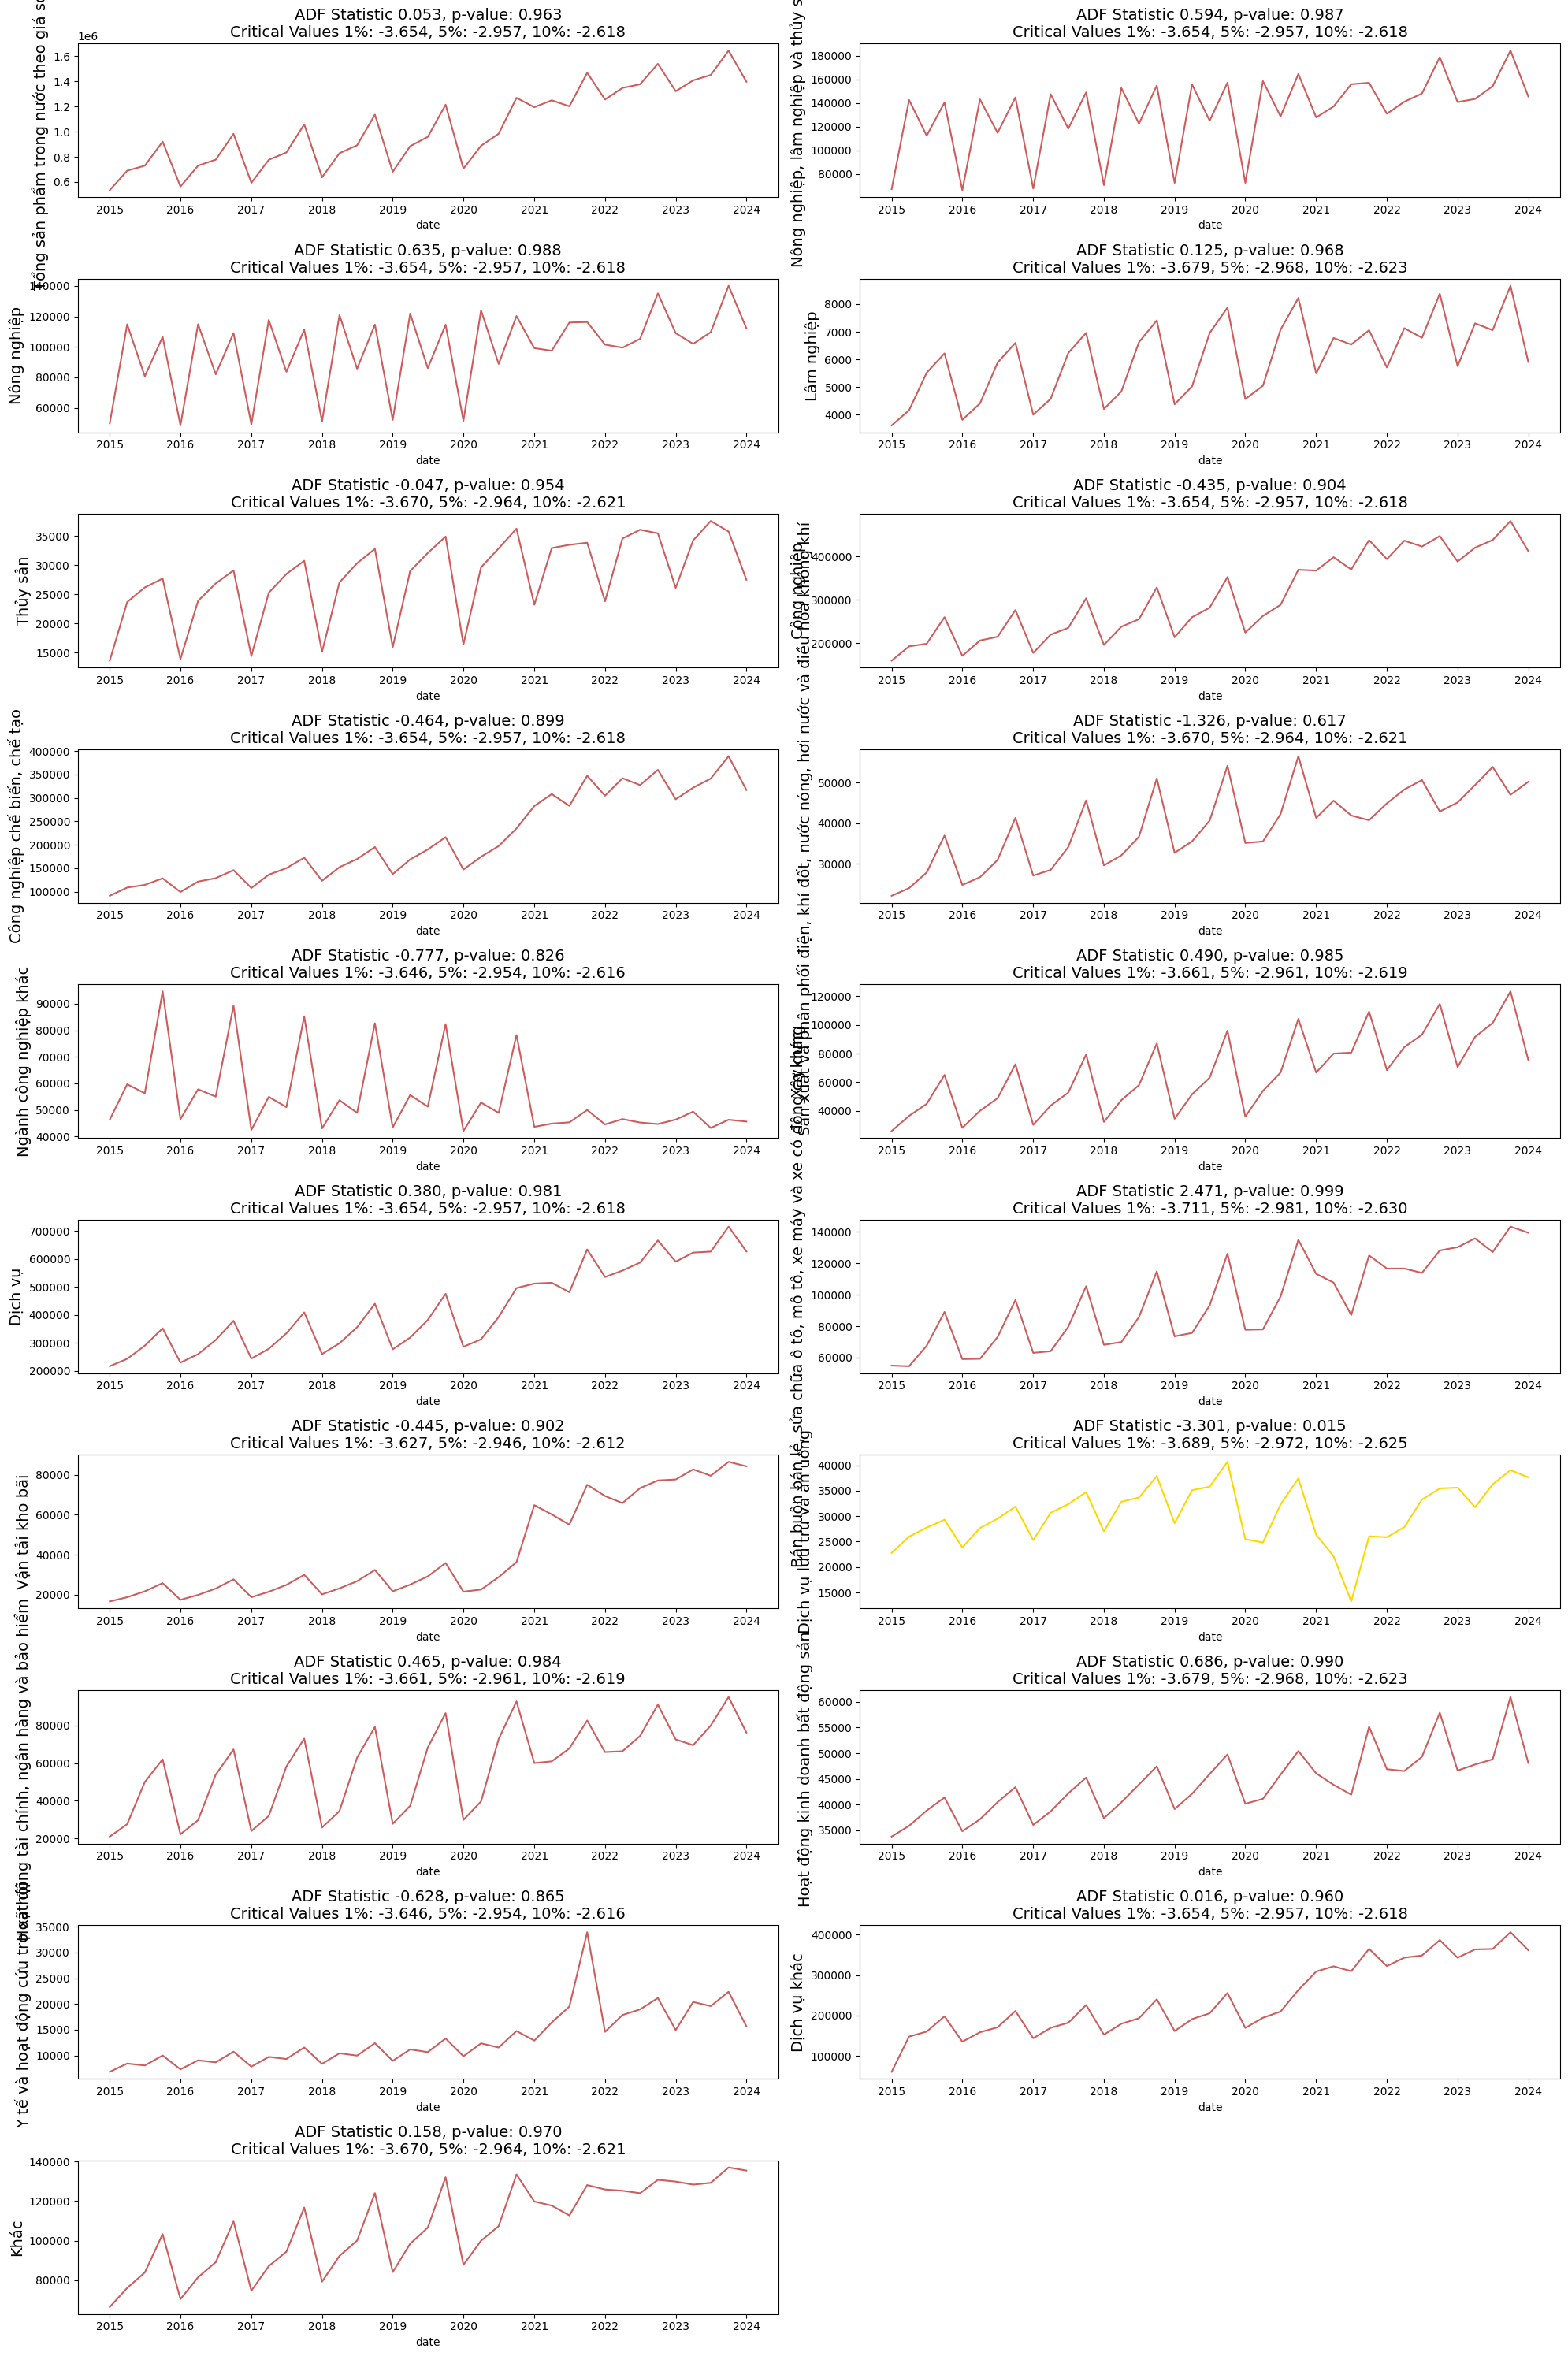

In [265]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Sample DataFrame creation for demonstration
# df = pd.read_csv('your_data.csv') # Load your data here

# Define the function to visualize ADF test results
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & (adf_stat < crit_val_1):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'

    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

# List of features to plot
features = [
    'Tổng sản phẩm trong nước theo giá so sánh', 'Nông nghiệp, lâm nghiệp và thủy sản ', 'Nông nghiệp', 'Lâm nghiệp',
    'Thủy sản', 'Công nghiệp', 'Công nghiệp chế biến, chế tạo',
    'Sản xuất và phân phối điện, khí đốt, nước nóng, hơi nước và điều hòa không khí ',
    'Ngành công nghiệp khác', 'Xây dựng', 'Dịch vụ',
    'Bán buôn bán lẻ, sửa chữa ô tô, mô tô, xe máy và xe có động cơ khác ',
    'Vận tải kho bãi', 'Dịch vụ lưu trú và ăn uống',
    'Hoạt động tài chính, ngân hàng và bảo hiểm ',
    'Hoạt động kinh doanh bất động sản ',
    'Y tế và hoạt động cứu trợ xã hội ', 'Dịch vụ khác', 'Khác'
]

# Create subplots
nrows = 10
ncols = 2
f, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 30))

# Flatten the axes array for easy iteration
ax = ax.flatten()

# Plot ADF test results for each feature
for i, feature in enumerate(features):
    visualize_adfuller_results(df[feature].values, feature, ax[i])

# Remove any empty subplots (if number of features is odd)
for j in range(i + 1, len(ax)):
    f.delaxes(ax[j])

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


Dựa vào biểu đồ của 'Tổng sản phẩm trong nước theo giá so sánh', ta thấy ADF > critical value hay p-value > significance level (default: 0.05)

Chứng tỏ 'Tổng sản phẩm trong nước theo giá so sánh' không đạt được yếu tố chuỗi dừng

=> Cần biến đổi sang chuỗi dừng bằng sai phân

In [266]:
# Define the function to visualize ADF test results
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & (adf_stat < crit_val_1):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'

    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)


### Differencing: subtracts the current value from the previous

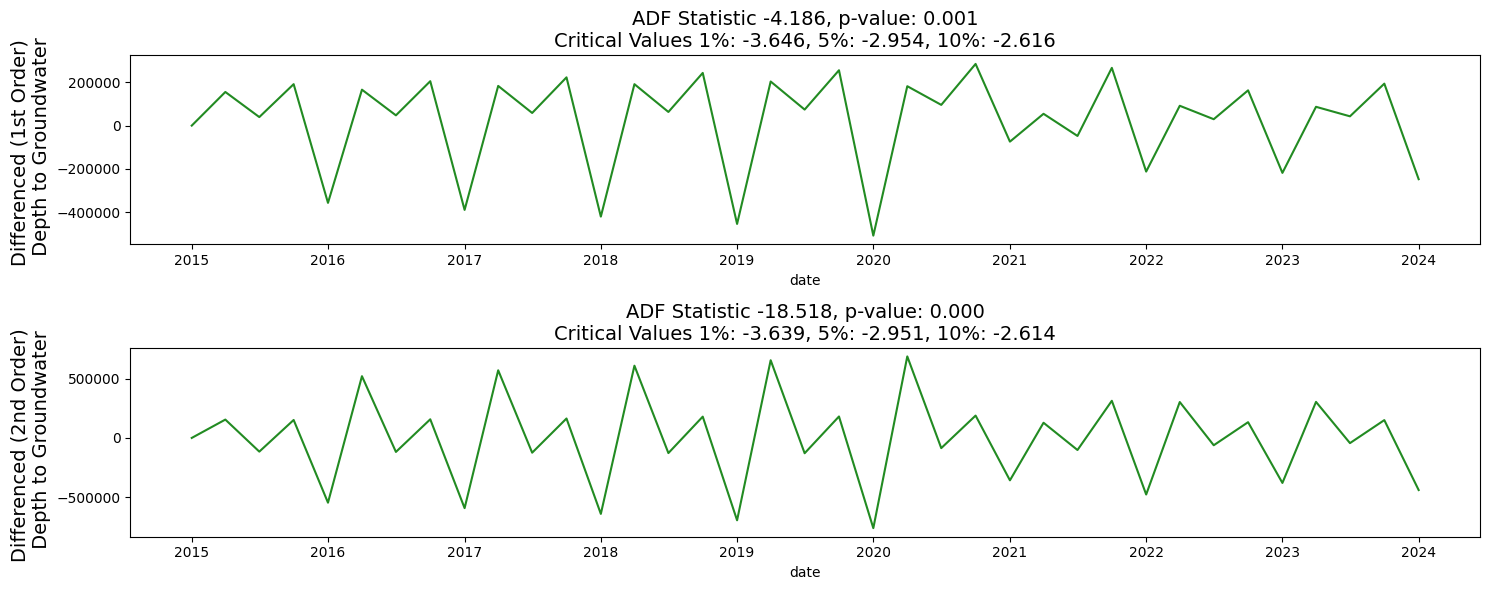

In [267]:
# First Order Differencing
ts_diff = np.diff(df['Tổng sản phẩm trong nước theo giá so sánh'])
df['Tổng sản phẩm trong nước theo giá so sánh diff1'] = np.append([0], ts_diff)

# Second Order Differencing
ts_diff = np.diff(df['Tổng sản phẩm trong nước theo giá so sánh diff1'])
df['Tổng sản phẩm trong nước theo giá so sánh diff2'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['Tổng sản phẩm trong nước theo giá so sánh diff1'], 'Differenced (1st Order) \n Depth to Groundwater', ax[0])
visualize_adfuller_results(df['Tổng sản phẩm trong nước theo giá so sánh diff2'], 'Differenced (2nd Order) \n Depth to Groundwater', ax[1])
plt.tight_layout()
plt.show()

=> Thỏa mãn yếu tố chuỗi dừng

In [268]:
print(df.columns)

Index(['date', 'Tổng sản phẩm trong nước theo giá so sánh',
       'Nông nghiệp, lâm nghiệp và thủy sản ', 'Nông nghiệp', 'Lâm nghiệp',
       'Thủy sản', 'Công nghiệp', 'Công nghiệp chế biến, chế tạo',
       'Sản xuất và phân phối điện, khí đốt, nước nóng, hơi nước và điều hòa không khí ',
       'Ngành công nghiệp khác', 'Xây dựng', 'Dịch vụ',
       'Bán buôn bán lẻ, sửa chữa ô tô, mô tô, xe máy và xe có động cơ khác ',
       'Vận tải kho bãi', 'Dịch vụ lưu trú và ăn uống',
       'Hoạt động tài chính, ngân hàng và bảo hiểm ',
       'Hoạt động kinh doanh bất động sản ',
       'Y tế và hoạt động cứu trợ xã hội ', 'Dịch vụ khác', 'Khác',
       'Tổng sản phẩm trong nước theo giá so sánh diff1',
       'Tổng sản phẩm trong nước theo giá so sánh diff2'],
      dtype='object')


In [269]:
df['Tổng sản phẩm trong nước theo giá so sánh'].equals(df['Tổng sản phẩm trong nước theo giá so sánh diff1'].cumsum() + df['Tổng sản phẩm trong nước theo giá so sánh'].iloc[0])

True

In [270]:
print(df.columns)

Index(['date', 'Tổng sản phẩm trong nước theo giá so sánh',
       'Nông nghiệp, lâm nghiệp và thủy sản ', 'Nông nghiệp', 'Lâm nghiệp',
       'Thủy sản', 'Công nghiệp', 'Công nghiệp chế biến, chế tạo',
       'Sản xuất và phân phối điện, khí đốt, nước nóng, hơi nước và điều hòa không khí ',
       'Ngành công nghiệp khác', 'Xây dựng', 'Dịch vụ',
       'Bán buôn bán lẻ, sửa chữa ô tô, mô tô, xe máy và xe có động cơ khác ',
       'Vận tải kho bãi', 'Dịch vụ lưu trú và ăn uống',
       'Hoạt động tài chính, ngân hàng và bảo hiểm ',
       'Hoạt động kinh doanh bất động sản ',
       'Y tế và hoạt động cứu trợ xã hội ', 'Dịch vụ khác', 'Khác',
       'Tổng sản phẩm trong nước theo giá so sánh diff1',
       'Tổng sản phẩm trong nước theo giá so sánh diff2'],
      dtype='object')


In [271]:
df.head()

,date,Tổng sản phẩm trong nước theo giá so sánh,"Nông nghiệp, lâm nghiệp và thủy sản",Nông nghiệp,Lâm nghiệp,Thủy sản,Công nghiệp,"Công nghiệp chế biến, chế tạo","Sản xuất và phân phối điện, khí đốt, nước nóng, hơi nước và điều hòa không khí",Ngành công nghiệp khác,...,"Bán buôn bán lẻ, sửa chữa ô tô, mô tô, xe máy và xe có động cơ khác",Vận tải kho bãi,Dịch vụ lưu trú và ăn uống,"Hoạt động tài chính, ngân hàng và bảo hiểm",Hoạt động kinh doanh bất động sản,Y tế và hoạt động cứu trợ xã hội,Dịch vụ khác,Khác,Tổng sản phẩm trong nước theo giá so sánh diff1,Tổng sản phẩm trong nước theo giá so sánh diff2
0,2015-01-01,535045.0,67012.0,49790.0,3617.0,13604.0,159521.0,91090.0,22078.0,46353.0,...,54948.0,16598.0,22767.0,20935.0,33735.0,6823.0,60504.0,66412.0,0.0,0.0
1,2015-04-01,690267.0,142640.0,114829.0,4163.0,23648.0,192341.0,108683.0,23971.0,59687.0,...,54547.0,18722.0,25992.0,27588.0,35846.0,8435.0,147794.0,76077.0,155222.0,155222.0
2,2015-07-01,729639.0,112372.0,80688.0,5521.0,26163.0,198579.0,114449.0,27839.0,56291.0,...,67580.0,21665.0,27749.0,49957.0,38819.0,8060.0,160057.0,83892.0,39372.0,-115850.0
3,2015-10-01,920906.0,140513.0,106617.0,6217.0,27679.0,259997.0,128390.0,36973.0,94633.0,...,89075.0,25746.0,29305.0,62053.0,41369.0,10004.0,197826.0,103293.0,191267.0,151895.0
4,2016-01-01,564371.0,66131.0,48451.0,3818.0,13863.0,170565.0,99236.0,24770.0,46558.0,...,59080.0,17401.0,23849.0,22189.0,34786.0,7307.0,135055.0,70430.0,-356535.0,-547802.0


## Feature Engineering

### Decomposition
The characteristics of a time series are

- Trend and Level
- Seasonality
- Random / Noise

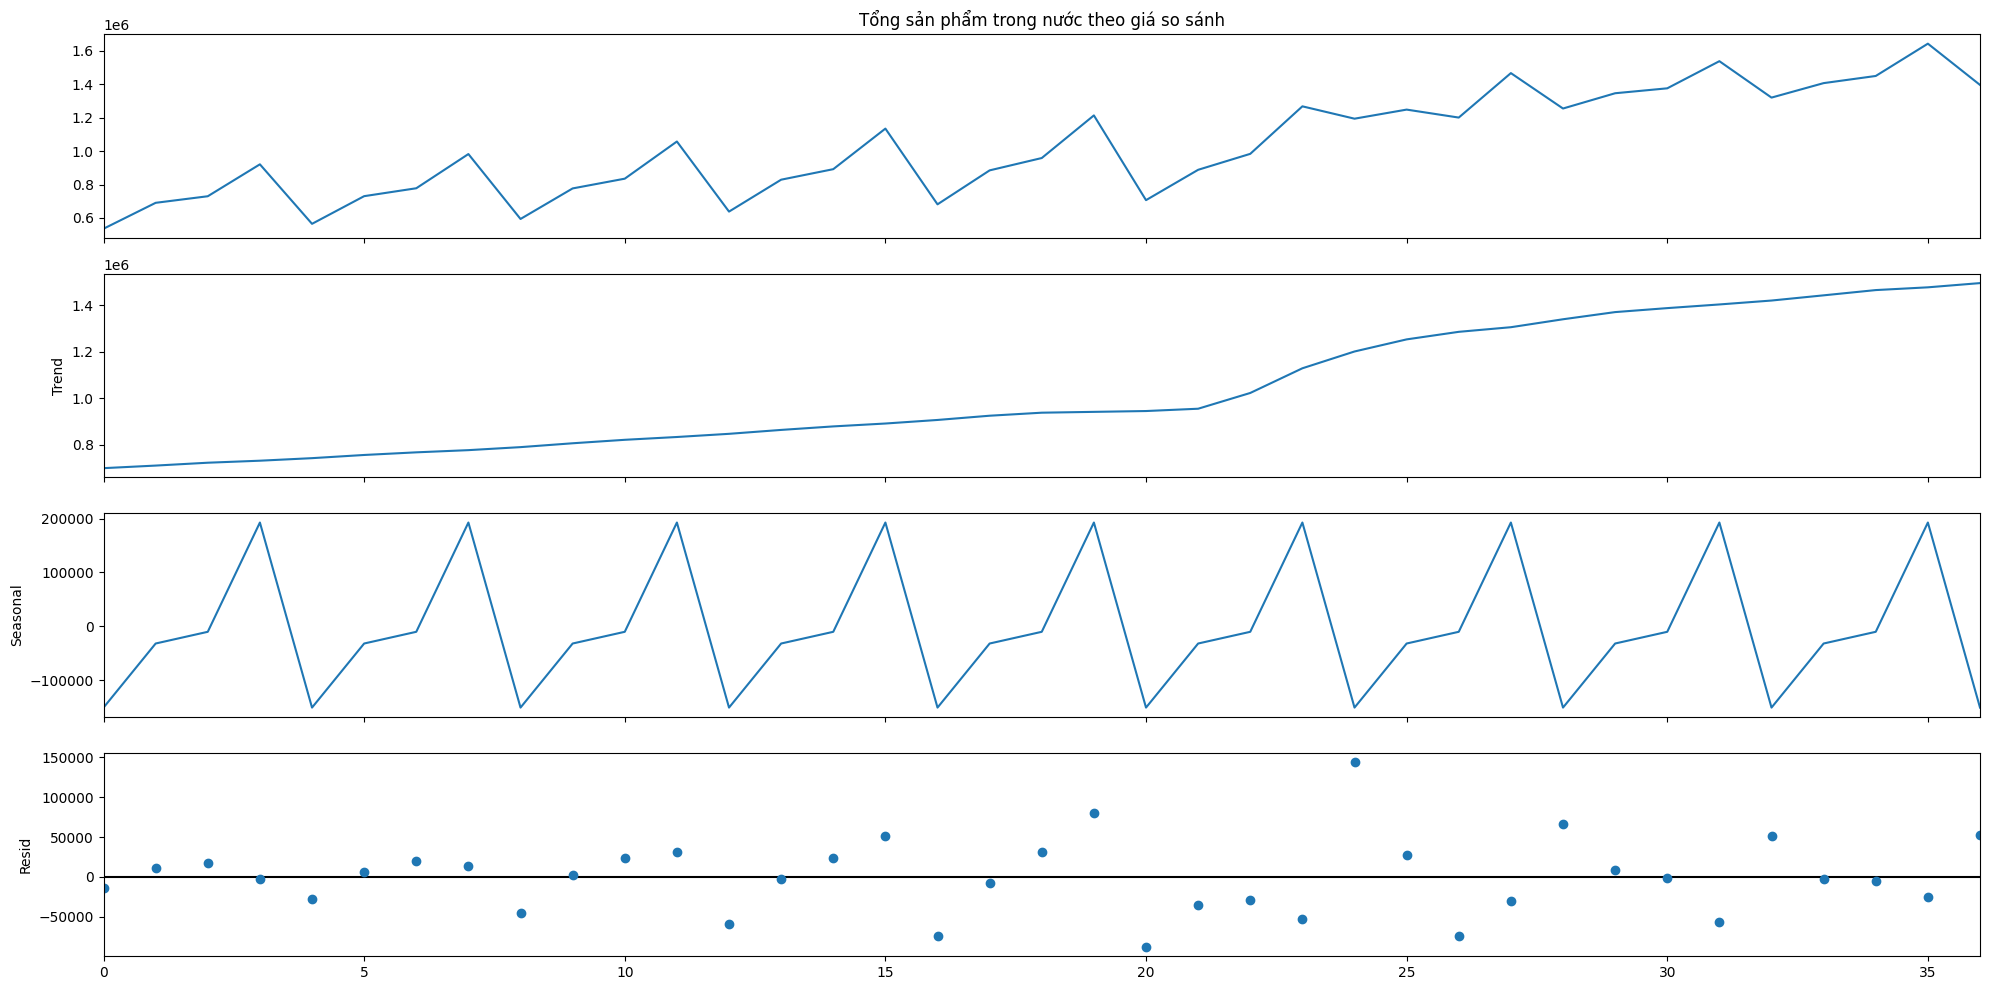

In [280]:
# Decompose the time series
results = seasonal_decompose(df['Tổng sản phẩm trong nước theo giá so sánh'], period=4, model='additive', extrapolate_trend='freq')
pyplot.rcParams['figure.figsize'] = (20.0, 10.0)
results.plot()
pyplot.show()

- Xu hướng tăng trưởng: GDP có xu hướng tăng trưởng ổn định qua các năm, phản ánh sự phát triển kinh tế.
- Biến động theo mùa: GDP bị ảnh hưởng rõ ràng bởi các yếu tố mùa vụ, với sự dao động đều đặn theo các khoảng thời gian nhất định.
- Yếu tố ngẫu nhiên: Sau khi loại bỏ xu hướng và thành phần mùa vụ, các yếu tố còn lại là ngẫu nhiên, cho thấy rằng không có yếu tố đặc biệt nào khác có ảnh hưởng đáng kể lên GDP.

## Exploratory Data Analysis

### Autocorrelation Analysis

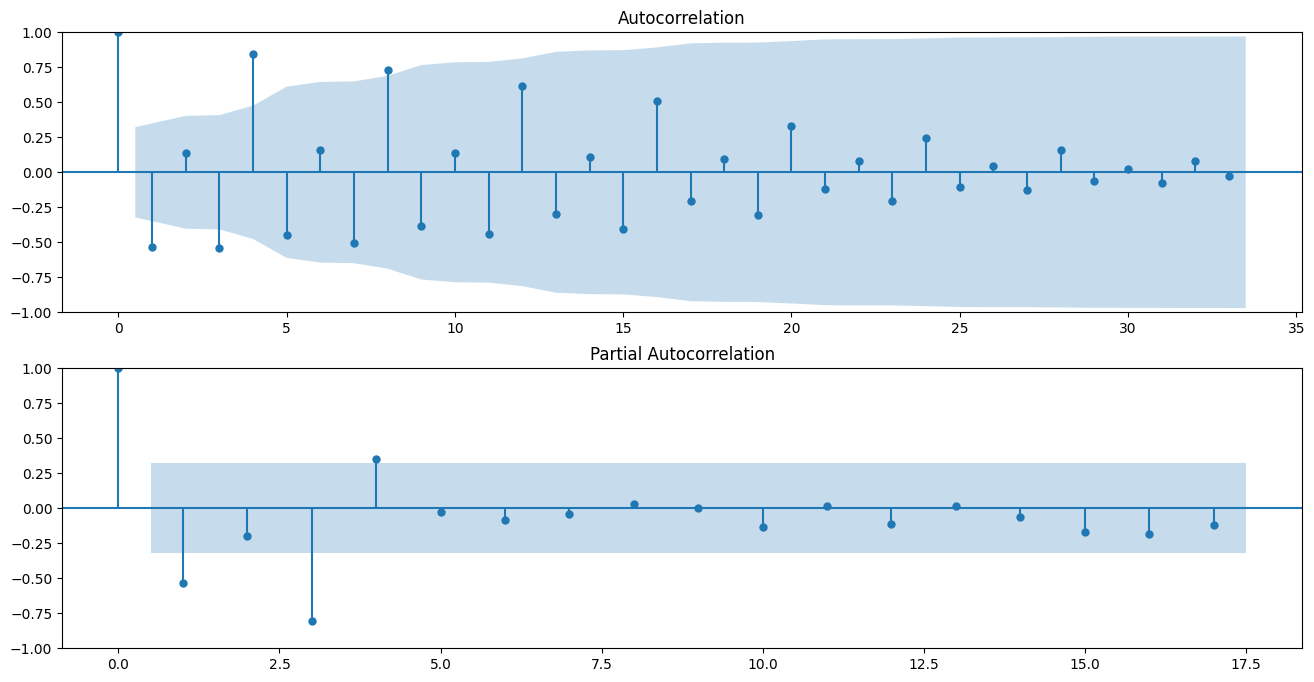

In [273]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['Tổng sản phẩm trong nước theo giá so sánh diff1'],lags=33, ax=ax[0])
plot_pacf(df['Tổng sản phẩm trong nước theo giá so sánh diff1'],lags=17, ax=ax[1])
plt.show()

## Cross Validation

In [274]:
X = df['date']
y = df['Tổng sản phẩm trong nước theo giá so sánh']

In [275]:
df['quarter_idx'] = (df.date != df.date.shift(1)).cumsum()

target = 'Tổng sản phẩm trong nước theo giá so sánh'
features = [feature for feature in df.columns if feature != target]

N_SPLITS = 30
X_train = df[df.quarter_idx < N_SPLITS][features]
y_train = df[df.quarter_idx < N_SPLITS][target]

X_test = df[df.quarter_idx >= N_SPLITS][features]
y_test = df[df.quarter_idx >= N_SPLITS][target]

## Model

### ARIMA

                                           SARIMAX Results                                           
Dep. Variable:     Tổng sản phẩm trong nước theo giá so sánh   No. Observations:                   29
Model:                                        ARIMA(3, 1, 3)   Log Likelihood                -380.932
Date:                                       Thu, 23 May 2024   AIC                            775.863
Time:                                               21:07:48   BIC                            785.189
Sample:                                                    0   HQIC                           778.714
                                                        - 29                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7033     

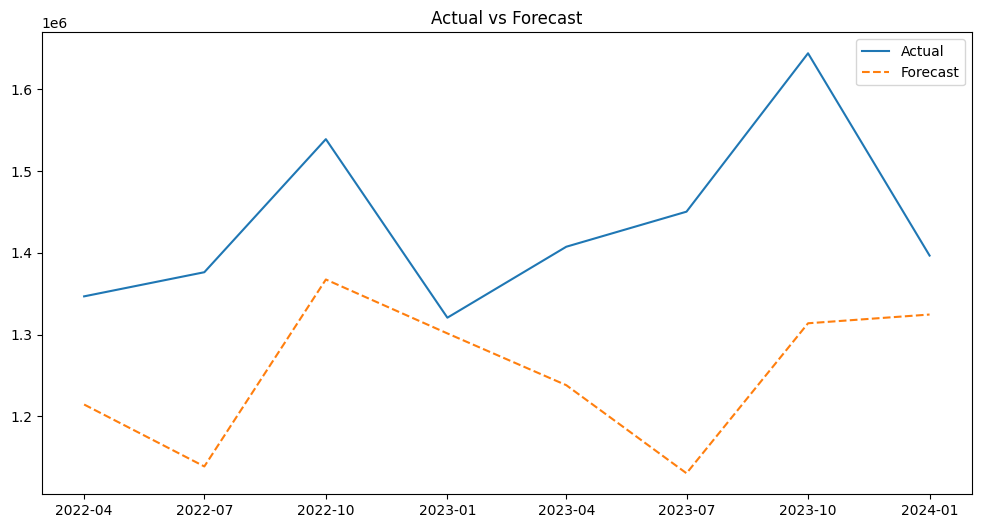

Overall MSE: 43568576929.02268


In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Fit ARIMA model (example with p=3, d=1, q=3)
model = ARIMA(y_train, order=(3, 1, 3))
model_fit = model.fit()
print(model_fit.summary())

# Forecast
forecast = model_fit.forecast(steps=len(y_test))
forecast = forecast.rename('Forecast')

# Create a new index with the desired start dates of each quarter
new_index = X_test['date']

# Assign this new index to the forecast DataFrame
forecast.index = new_index
y_test.index = new_index

print(y_test)
print(forecast)
# Calculate MSE and RMSE
mse = mean_squared_error(y_test, forecast)

# Plot the forecast against the actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.legend()
plt.title('Actual vs Forecast')
plt.show()

# Print the overall MSE and RMSE
print(f'Overall MSE: {mse}')

- Giai đoạn 2022-04 đến 2022-10: Giá trị dự báo thấp hơn so với giá trị thực tế, đặc biệt là vào khoảng 2022-07.
- Giai đoạn 2022-10 đến 2023-01: Giá trị dự báo và giá trị thực tế có xu hướng giảm nhưng dự báo không bắt kịp mức giảm đột ngột của giá trị thực tế.
- Giai đoạn 2023-01 đến 2023-07: Mô hình dự báo xu hướng giảm nhưng mức giảm không sát với thực tế.
- Giai đoạn 2023-07 đến 2023-10: Giá trị dự báo tiếp tục không theo kịp sự tăng vọt trong giá trị thực tế.
- Giai đoạn 2023-10 đến 2024-01: Mô hình dự báo một xu hướng tăng nhưng vẫn chưa đủ để phản ánh mức tăng thực tế.

Đề xuất Cải thiện:
- Điều chỉnh tham số của mô hình ARIMA: Có thể thử nghiệm các tham số khác nhau (p, d, q) để cải thiện độ chính xác của dự báo.
- Sử dụng các mô hình khác: Có thể xem xét sử dụng các mô hình khác như SARIMA (Seasonal ARIMA), để dự báo chuỗi thời gian.

### SARIMA

In [277]:
from scipy import stats
# Fit the model
stepwise_fit = pm.auto_arima(y_train,
                             start_p=0, start_q=0, max_p=5, max_q=5,
                             d=None, max_d=2,
                             start_P=0, start_Q=0, max_P=5, max_D=2, max_Q=5,
                             seasonal=True, m=4,  # m=4 for quarterly data
                             stepwise=True, trace=True,
                             error_action='ignore', suppress_warnings=True,
                             information_criterion='aic',
                             n_fits=100)

# Print the summary of the best model
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,2,0)[4]             : AIC=568.001, Time=0.01 sec
 ARIMA(1,0,0)(1,2,0)[4]             : AIC=565.053, Time=0.05 sec
 ARIMA(0,0,1)(0,2,1)[4]             : AIC=564.584, Time=0.05 sec
 ARIMA(0,0,1)(0,2,0)[4]             : AIC=567.698, Time=0.03 sec
 ARIMA(0,0,1)(1,2,1)[4]             : AIC=565.700, Time=0.11 sec
 ARIMA(0,0,1)(0,2,2)[4]             : AIC=565.672, Time=0.10 sec
 ARIMA(0,0,1)(1,2,0)[4]             : AIC=566.964, Time=0.05 sec
 ARIMA(0,0,1)(1,2,2)[4]             : AIC=567.662, Time=0.18 sec
 ARIMA(0,0,0)(0,2,1)[4]             : AIC=573.549, Time=0.04 sec
 ARIMA(1,0,1)(0,2,1)[4]             : AIC=563.865, Time=0.07 sec
 ARIMA(1,0,1)(0,2,0)[4]             : AIC=566.882, Time=0.08 sec
 ARIMA(1,0,1)(1,2,1)[4]             : AIC=565.861, Time=0.14 sec
 ARIMA(1,0,1)(0,2,2)[4]             : AIC=565.861, Time=0.14 sec
 ARIMA(1,0,1)(1,2,0)[4]             : AIC=567.779, Time=0.09 sec
 ARIMA(1,0,1)(1,2,2)[4]             : AIC=567.8

            SARIMA_Forecast
date                       
2022-04-01     1.332109e+06
2022-07-01     1.284760e+06
2022-10-01     1.586305e+06
2023-01-01     1.386645e+06
2023-04-01     1.459122e+06
Overall MSE: 5538799518.056155


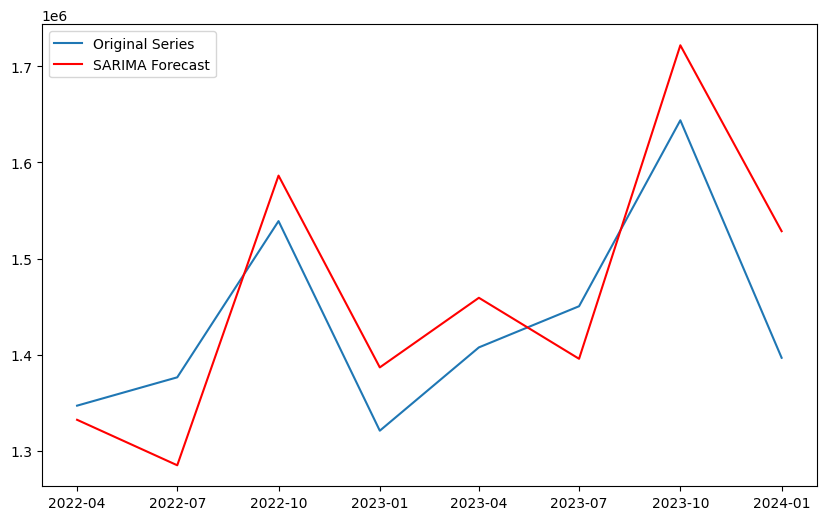

In [278]:
# Make predictions
SARIMA_Forecast = pd.DataFrame(stepwise_fit.predict(n_periods=len(y_test)), columns=['SARIMA_Forecast'])

# Create a new index with the desired start dates of each quarter
new_index = X_test['date']

# Assign this new index to the forecast DataFrame
SARIMA_Forecast.index = new_index
y_test.index = new_index

# Display the forecast
print(SARIMA_Forecast.head())

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, SARIMA_Forecast)
print(f'Overall MSE: {mse}')
# Plotting the results

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Original Series')
plt.plot(SARIMA_Forecast, label='SARIMA Forecast', color='red')
plt.legend(loc='best')
plt.show()

- Giai đoạn 2022-04 đến 2022-10: Giá trị dự báo của SARIMA thấp hơn so với giá trị thực tế trong các tháng đầu tiên nhưng tăng đột ngột trong tháng 2022-10, vượt qua giá trị thực tế.
- Giai đoạn 2022-10 đến 2023-01: Dự báo của SARIMA tiếp tục cao hơn so với giá trị thực tế vào khoảng cuối năm 2022.
- Giai đoạn 2023-01 đến 2023-04: Mô hình dự báo xu hướng giảm nhưng không bắt kịp mức giảm của giá trị thực tế.
- Giai đoạn 2023-04 đến 2023-07: Giá trị dự báo của SARIMA có xu hướng giảm nhưng lại không phản ánh đúng mức tăng của giá trị thực tế.
- Giai đoạn 2023-07 đến 2023-10: Mô hình dự báo một mức tăng lớn, vượt qua giá trị thực tế.
- Giai đoạn 2023-10 đến 2024-01: Dự báo của SARIMA giảm nhưng vẫn cao hơn so với giá trị thực tế.

=> Mô hình SARIMA đã cải thiện độ chính xác so với mô hình ARIMA thông qua việc nắm bắt các biến động theo mùa, nhưng vẫn chưa thể phản ánh chính xác các biến động ngắn hạn và bất thường trong dữ liệu thực tế.